In [1]:
import pandas as pd

X = pd.read_csv('essaysense/datasets/training_set_rel3.tsv', sep='\t', encoding='ISO-8859-1')
y = X['domain1_score']

In [2]:
from tqdm import tqdm

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
import nltk

In [5]:
from nlp_adversarial_examples import glove_utils

In [6]:
GLOVE_PATH = 'essaysense/datasets/glove.840B.300d.txt'

In [7]:
glove_model = glove_utils.loadGloveModel(GLOVE_PATH)

Loading Glove Model
Done. 2196007  words loaded!


In [10]:
import os

class HyperParameters:
    """Hyper-parameters of this project.

    This is a class holding necessary hyperparameters of this project. Instan-
    tiation of the class can get all of the parameters. Note that property
    protection is not constructed, so DO NOT change the values unless you know
    what you are doing.
    """
    def __init__(self):
        self.train_epochs = 700  # General training epochs.
#         self.w_dim = 50  # Word embedding dimension.
        self.w_dim = 300  # Word embedding dimension.
        self.s_len = 20  # Sentence length in the sentence-level models.
        self.e_len = 60  # Essay length in the sentence-level models.
        self.w_window_len = 5  # Convolution window size of word level.
        self.s_window_len = 3  # Convolution window size of sentence level.
        self.w_convunits_size = 64  # Convolution unit number of word level.
        self.s_convunits_size = 32 # Convolution unit number of sentence level.
        self.hidden_size = 100  # Dense layer size of sentence-level models.
        self.batch_size = 20  # Batch size.
        self.learning_rate = 0.006  # Initial learning rate.
        self.dropout_keep_prob = 0.3  # Dropout rate.
        self.d_e_len = 500  # Essay length in the document-level models.
        self.lstm_hidden_size = 150  # Dense layer size of LSTM models.
        self.cnn_lstm_convunits_size = 80  # Conv units of CNN-LSTM models.
        self.cnn_lstm_att_pool_size = 50  # Attention pool size.

class ProjectPaths:
    """Project paths of the application."""
    def __init__(self):
        self.aes_root = "essaysense"  # Temporarily
        self.tfmetadata = os.path.join(self.aes_root, "tfmetadata")
        self.datasets_root = os.path.join(self.aes_root, "datasets")
        self.asap = os.path.join(self.datasets_root, "training_set_rel3.tsv")
        self.asap_train = os.path.join(self.datasets_root, "train.tsv")
        self.asap_dev = os.path.join(self.datasets_root, "dev.tsv")
        self.asap_test = os.path.join(self.datasets_root, "test.tsv")
        self.asap_url = "http://p2u3jfd2o.bkt.clouddn.com/datasets/training_set_rel3.tsv"
#         self.glove = os.path.join(self.datasets_root, "glove.6B.50d.txt")
        self.glove = os.path.join(self.datasets_root, "glove.840B.300d.txt")
        self.glove_url = "http://p2u3jfd2o.bkt.clouddn.com/datasets/glove.6B.50d.txt"

    def model(self, model_name):
        return os.path.join(self.tfmetadata, model_name, "model.ckpt")

    def model_ckpt(self, model_name):
        return os.path.join(self.tfmetadata, model_name)

    def summary(self, model_name):
        return os.path.join(self.tfmetadata, model_name, "summary")


# Variables to export.
hp = hyperparameters = HyperParameters()
paths = ProjectPaths()


In [11]:
import os

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [12]:
import tensorflow as tf
from tensorflow.contrib import rnn as tfrnn

In [13]:
def define_graph():
    tf.reset_default_graph()
    essays = tf.placeholder(tf.float32, [None, hp.d_e_len,
                                         hp.w_dim])
    scores = tf.placeholder(tf.float32, [None])
    keep_prob = tf.placeholder_with_default(tf.constant(1.0, dtype=tf.float32), ())

    # Long Short-Term Memory layer
    lstm_cell = tfrnn.BasicLSTMCell(num_units=hp.lstm_hidden_size)
    lstm_cell = tfrnn.DropoutWrapper(
        cell=lstm_cell,
        output_keep_prob=keep_prob)
    init_state = lstm_cell.zero_state(hp.batch_size, dtype=tf.float32)
    lstm, _ = tf.nn.dynamic_rnn(lstm_cell, essays, dtype=tf.float32)

    # Mean over Time pooling
    mot = tf.reduce_mean(lstm, axis=1)

    # Dense layer
    dense = tf.layers.dense(inputs=mot, units=1, activation=tf.nn.sigmoid)

    # Prediction and Loss
    preds = tf.reshape(dense, [-1])
    loss = tf.losses.mean_squared_error(scores, preds)

    return (essays,
            scores,
            keep_prob,
            loss,
            preds)

In [14]:
import numpy as np

In [15]:
score_range = {1: (2, 12),
               2: (1, 6),
               3: (0, 3),
               4: (0, 3),
               5: (0, 4),
               6: (0, 4),
               7: (0, 30),
               8: (0, 60)}

In [16]:
score_range_min = np.array([2, 1, 0, 0, 0, 0, 0, 0])
score_range_max = np.array([12, 6, 3, 3, 4, 4, 30, 60])

In [17]:
def shrink(scores, essay_set):
    mini = np.choose(essay_set-1,score_range_min)
    maxi = np.choose(essay_set-1,score_range_max)
    
    return (scores - mini) / (maxi - mini)

def expand(scores, essay_set):
    mini = np.choose(essay_set-1,score_range_min)
    maxi = np.choose(essay_set-1,score_range_max)
    
    return np.array(np.round(scores * (maxi - mini) + mini),dtype=int)

In [18]:
def normalize_score(score, essay_set):
    return (float(score) - score_range[essay_set][0]) / float(score_range[essay_set][1] - score_range[essay_set][0])

In [19]:
glove_vectors = glove_model

In [20]:
def document_level_tokenize(essay_text):
    essay_text = essay_text.encode('ascii', errors='ignore').decode('utf-8', errors='ignore')
    essay_text = essay_text.lower()  # Use lower-cases for word embeddings.
    essay_text = essay_text.replace('/', ' / ')
    essay_text = essay_text.replace('@', ' ')
    essay_text = essay_text.replace('.', ' . ')
    essay_text = essay_text.replace('-', ' - ')
    essay = nltk.word_tokenize(essay_text)
    essay = list(map(lambda x : (x[:-1] if x[-1].isdigit() else x), essay))
    essay = list(filter(lambda x: len(x) > 0, essay))
    return essay

In [21]:
def data_generator(data, labels, corrections=False):
    cnt_corrections = 0
    set_size = len(data)
    i_item = 0
    while True:
        if i_item >= set_size:
            i_item = 0
        
        if type(data) is pd.DataFrame:
            item = data.iloc[i_item]
            label = labels.iloc[i_item]
            essay_text = document_level_tokenize(item['essay'])
        else:
            item = data[i_item]
            label = labels[i_item]
            essay_text = document_level_tokenize(item)
            
        embedded = np.zeros([hp.d_e_len, hp.w_dim])
        for i in range(min(len(essay_text), hp.d_e_len)):
            if corrections and essay_text[i] in corrections_dict.keys():
                essay_text[i] = corrections_dict[essay_text[i]]
            
            embedded[i] = glove_vectors.get(essay_text[i], np.zeros(hp.w_dim))
            
        i_item += 1
        
        if type(data) is pd.DataFrame: 
            yield (embedded, normalize_score(label, item["essay_set"]))
        else:
            yield (embedded, normalize_score(label, 1))
        

In [22]:
def next_batch(gen, size_demand):
    essays_batched = []
    scores_batched = []
    for _ in range(size_demand):
        next_item = next(gen)  # Generate next item
        essays_batched.append(next_item[0])
        scores_batched.append(next_item[1])
    essays_batched = np.array(essays_batched)
    scores_batched = np.array(scores_batched)
    return essays_batched, scores_batched

In [23]:
class AES():
    def __init__(self):
        pass
        
        
    def predict(self, sess, list_essays):
        all_embedded = np.zeros([len(list_essays), hp.d_e_len, hp.w_dim])
        all_preds = np.zeros([len(list_essays), 2])
        
        for index in range(len(list_essays)):
            essay = list_essays[index]
            embedded = np.zeros([hp.d_e_len, hp.w_dim])
            for i in range(min(len(essay), hp.d_e_len)):
                embedded[i] = glove_model.get(full_inv_dict[essay[i]], np.zeros([hp.w_dim]))
            all_embedded[index] = embedded

        preds_got = sess.run(preds, feed_dict={essays: all_embedded})
        all_preds[:,0] = 1 - preds_got
        all_preds[:,1] = preds_got
        
        return all_preds
    
aes = AES()

In [24]:
(essays,
 scores,
 keep_prob,
 loss,
 preds) = define_graph()

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [25]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(graph=tf.get_default_graph(), config=tf.ConfigProto(gpu_options=gpu_options))

In [26]:
saver = tf.train.Saver(tf.trainable_variables())
saver.restore(sess, './models/LSTM_2_wo_corr')

INFO:tensorflow:Restoring parameters from ./models/LSTM_2_wo_corr


In [27]:
from sklearn.metrics import cohen_kappa_score

In [175]:
data_gen = data_generator(X[X['essay_set']==1], y[X['essay_set']==1])

In [176]:
(all_test_essays,
 all_test_scores) = next_batch(data_gen, (X['essay_set']==1).sum())

In [177]:
preds_got = sess.run(preds, feed_dict={essays: all_test_essays, scores: all_test_scores, keep_prob: 1.0})

In [178]:
cohen_kappa_score(expand(preds_got, 1), y[X['essay_set']==1], weights='quadratic')

0.8109842230661793

In [110]:
tokens = list(set(document_level_tokenize(X['essay'].iloc[0])))
len(tokens)

173

In [111]:
data_gen = data_generator([" ".join([x]*len(tokens)) for x in tokens], [y.iloc[0]]*len(tokens))

In [112]:
(all_test_essays,
 all_test_scores) = next_batch(data_gen, len(tokens))

In [113]:
preds_got = sess.run(preds, feed_dict={essays: all_test_essays, scores: all_test_scores, keep_prob: 1.0})

(array([ 1.,  0., 34.,  0., 97.,  0., 28.,  0.,  9.,  4.]),
 array([4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. , 8.5, 9. ]),
 <a list of 10 Patch objects>)

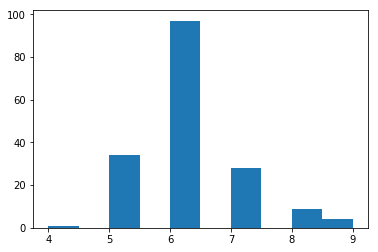

In [114]:
plt.hist(expand(preds_got, 1))

In [407]:
all_unique = []
all_counts = []

In [404]:
unique, counts = np.unique(expanded, return_counts=True)

In [28]:
all_unique = []
all_counts = []
all_all_preds = []
all_all_words = []

for ess_set in range(1, 9):
    
    saver = tf.train.Saver(tf.trainable_variables())
    saver.restore(sess, './models/LSTM_{}_wo_corr'.format(ess_set))

    all_words = []

    for essay in X[X['essay_set']==ess_set]['essay']:
        all_words = all_words + document_level_tokenize(essay)
        
    all_words =  list(set(all_words))
    
    all_preds = []
    
    data_gen = data_generator([" ".join([x]*500) for x in all_words], [y.iloc[0]]*len(all_words))
    
    for i in tqdm(range(len(all_words)//1000)):
        (all_test_essays, all_test_scores) = next_batch(data_gen, 1000)
        preds_got = sess.run(preds, feed_dict={essays: all_test_essays, scores: all_test_scores, keep_prob: 1.0})
        all_preds.append(preds_got)
        
    all_preds = np.array(all_preds).reshape(-1)
    all_preds = expand(all_preds, ess_set)
    
    unique, counts = np.unique(all_preds, return_counts=True)
    
    all_unique.append(unique)
    all_counts.append(counts)
    all_all_preds.append(all_preds)
    all_all_words.append(all_words)

INFO:tensorflow:Restoring parameters from ./models/LSTM_1_wo_corr


100%|██████████| 15/15 [01:12<00:00,  4.77s/it]

INFO:tensorflow:Restoring parameters from ./models/LSTM_2_wo_corr



100%|██████████| 14/14 [01:08<00:00,  4.93s/it]

INFO:tensorflow:Restoring parameters from ./models/LSTM_3_wo_corr



100%|██████████| 6/6 [00:29<00:00,  4.95s/it]

INFO:tensorflow:Restoring parameters from ./models/LSTM_4_wo_corr



100%|██████████| 4/4 [00:20<00:00,  5.16s/it]

INFO:tensorflow:Restoring parameters from ./models/LSTM_5_wo_corr



100%|██████████| 4/4 [00:20<00:00,  5.01s/it]

INFO:tensorflow:Restoring parameters from ./models/LSTM_6_wo_corr



100%|██████████| 5/5 [00:25<00:00,  5.18s/it]

INFO:tensorflow:Restoring parameters from ./models/LSTM_7_wo_corr



100%|██████████| 10/10 [00:49<00:00,  4.80s/it]

INFO:tensorflow:Restoring parameters from ./models/LSTM_8_wo_corr



100%|██████████| 11/11 [00:54<00:00,  4.97s/it]


In [29]:
1

1

In [31]:
len(all_all_preds[0])

15000

In [38]:
all_counts

[array([  10,  995, 1665, 4241, 1270, 1375, 1351, 1226,  990, 1420,  457]),
 array([2847, 4758, 1626, 1045,  828, 2896]),
 array([ 272, 2066,  510, 3152]),
 array([1137,  974,  172, 1717]),
 array([ 386, 1395,  254,  265, 1700]),
 array([ 558, 1769,  237,  259, 2177]),
 array([ 215,  976,  601,  450,  374,  322,  274,  254,  209,  199, 1756,
         159,  128,  139,  120,   93,   72,   74,   70,   73,   72,   76,
          89,   93,  130,  141,  205,  276,  545, 1157,  658]),
 array([  3,   5,  22,  38,  61,  71,  91, 106, 113,  99,  93, 118, 134,
        135, 169, 145, 192, 184, 565, 176, 210, 200, 220, 232, 190, 196,
        173, 187, 183, 180, 150, 128, 115, 124, 123, 105,  86, 110, 107,
        139, 115, 137, 123, 137, 167, 222, 270, 309, 354, 435, 499, 616,
        667, 621, 472, 174,   4])]

In [69]:
all_unique

[array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([1, 2, 3, 4, 5, 6]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3, 4]),
 array([0, 1, 2, 3, 4]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59])]

In [41]:
all_unique[-1]

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59])

In [62]:
bins = [list(range(3*i+1,3*i+4)) for i in range(10)]

In [63]:
bins

[[1, 2, 3],
 [4, 5, 6],
 [7, 8, 9],
 [10, 11, 12],
 [13, 14, 15],
 [16, 17, 18],
 [19, 20, 21],
 [22, 23, 24],
 [25, 26, 27],
 [28, 29, 30]]

In [65]:
bins_cnt = np.zeros(10)

In [ ]:
all_unique

In [53]:
all_unique[-1]

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59])

In [55]:
np.where(list(map(lambda x: x in bins[i], all_unique[-1])))[0]

array([0, 1, 2])

In [70]:
for i in range(10):
    bins_cnt[i] = np.sum(all_counts[-2][np.where(list(map(lambda x: x in bins[i], all_unique[-2])))[0]])

In [68]:
bins_cnt

array([2027.,  970.,  662., 2043.,  352.,  216.,  221.,  312.,  622.,
       2360.])

In [58]:
bins_cnt

array([  30.,  367.,  557.,  825., 1371.,  978.,  756.,  548.,  621.,
       1105., 2571., 1271.])

In [40]:
all_counts[-1].reshape((10,-1))

ValueError: cannot reshape array of size 57 into shape (10,newaxis)

In [35]:
for ess_set in range(8):
    print([(all_all_words[ess_set][i],all_all_preds[ess_set][i]) for i in np.argsort(all_all_preds[ess_set])][-20:])

[('serial', 12), ('six', 12), ('data', 12), ('creating', 12), ('continuously', 12), ('roughly', 12), ('associated', 12), ('previously', 12), ('shares', 12), ('account', 12), ('accounts', 12), ('occurs', 12), ('gray', 12), ('behavior', 12), ('communications', 12), ('characters', 12), ('carried', 12), ('abilities', 12), ('set', 12), ('television', 12)]
[('persecution', 6), ('innocence', 6), ('cocaine', 6), ('decades', 6), ('centered', 6), ('geographic', 6), ('solving', 6), ('permanently', 6), ('posed', 6), ('bullies', 6), ('outcomes', 6), ('uniqueness', 6), ('unusual', 6), ('lure', 6), ('conform', 6), ('harshly', 6), ('govern', 6), ('nasty', 6), ('pubescent', 6), ('ethnicity', 6)]
[('sort', 3), ('pours', 3), ('crested', 3), ('forest', 3), ('thrown', 3), ('sending', 3), ('physical', 3), ('makes', 3), ('combined', 3), ('tone', 3), ('cold', 3), ('on', 3), ('crafted', 3), ('fairly', 3), ('temperatures', 3), ('talking', 3), ('savor', 3), ('some', 3), ('efforts', 3), ('strangers', 3)]
[('figur

(array([  10.,  995., 1665., 4241., 1270., 1375., 1351., 1226.,  990.,
        1877.]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 <a list of 10 Patch objects>)

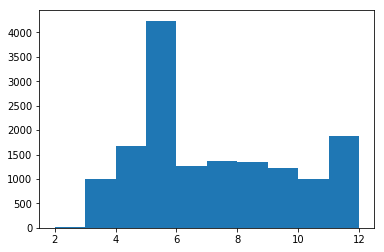

In [37]:
plt.hist(all_all_preds[0])

In [124]:
data_gen = data_generator([" ".join([x]*len(tokens)) for x in all_words], [y.iloc[0]]*len(all_words))

In [121]:
(all_test_essays,
 all_test_scores) = next_batch(data_gen, len(all_words))

In [125]:
all_preds = []

In [126]:
for i in tqdm(range(len(all_words)//1000)):
    (all_test_essays, all_test_scores) = next_batch(data_gen, 1000)
    preds_got = sess.run(preds, feed_dict={essays: all_test_essays, scores: all_test_scores, keep_prob: 1.0})
    all_preds.append(preds_got)

100%|██████████| 15/15 [00:42<00:00,  2.91s/it]


In [128]:
all_preds = np.array(all_preds).reshape(-1)

(array([ 1.,  0., 34.,  0., 97.,  0., 28.,  0.,  9.,  4.]),
 array([4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. , 8.5, 9. ]),
 <a list of 10 Patch objects>)

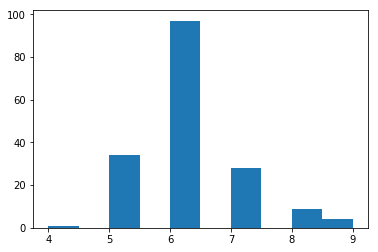

In [114]:
plt.hist(expand(preds_got, 1))

In [134]:
[all_words[i] for i in np.argsort(all_preds)][-20:]

['color',
 'data',
 'features',
 'communication',
 'intelligence',
 'thousands',
 'grew',
 'among',
 'network',
 'number',
 'organization',
 'operations',
 'countries',
 'became',
 'humans',
 ',',
 'pages',
 'percent',
 'characters',
 'world']

In [138]:
[expanded[i] for i in np.argsort(all_preds)][-20:]

[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]

In [137]:
expanded = expand(all_preds, 1)

(array([   8., 2499.,    0., 7044.,    0., 3119., 1541.,    0.,  720.,
          69.]),
 array([3. , 3.6, 4.2, 4.8, 5.4, 6. , 6.6, 7.2, 7.8, 8.4, 9. ]),
 <a list of 10 Patch objects>)

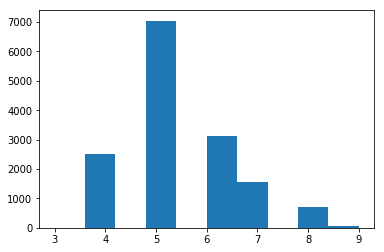

In [129]:
plt.hist(expand(all_preds, 1))

In [143]:
cohen_kappa_score(y[X['essay_set']==2], np.round(np.ones_like(y[X['essay_set']==2]) * y[X['essay_set']==2].mean()))

0.0

In [147]:
from sklearn.model_selection import train_test_split

In [235]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, stratify=X['essay_set'])


# Confusion matrices

In [384]:
ess_set = 8

In [385]:
saver = tf.train.Saver(tf.trainable_variables())
saver.restore(sess, './models/LSTM_{}_wo_corr'.format(ess_set))

INFO:tensorflow:Restoring parameters from ./models/LSTM_8_wo_corr


In [386]:
X_test = X_train
y_test = y_train

In [387]:
test_gen = data_generator(X_test[X_test['essay_set']==ess_set], y_test[X_test['essay_set']==ess_set])

In [388]:
(all_test_essays,
 all_test_scores) = next_batch(test_gen, len(X_test[X_test['essay_set']==ess_set]))

In [389]:
preds_got = sess.run(preds, feed_dict={essays: all_test_essays, scores: all_test_scores, keep_prob: 1.0})

In [390]:
cohen_kappa_score(expand(preds_got, ess_set), y_test[X_test['essay_set']==ess_set], weights='quadratic')

0.7570335222836394

In [391]:
import seaborn as sns

In [392]:
preds_got.shape

(578,)

In [393]:
y_test[X_test['essay_set']==ess_set].values.shape

(578,)

In [394]:
sns_data = pd.DataFrame(index=range(len(preds_got)))

In [395]:
def groupify(x):
    scale = 60
    groups = 10
    group_size = scale//groups
    return "{:>2d}-{:>2d}".format(x // group_size * group_size, (x // group_size * group_size + group_size-1))

In [396]:
sns_data['Predictions'] = list(map(groupify, expand(preds_got, ess_set)))

In [397]:
sns_data['Actual marks'] = list(map(groupify, y_test[X_test['essay_set']==ess_set].values))

In [398]:
sns_data = sns_data.groupby(by=['Predictions', 'Actual marks']).size().to_frame().unstack().fillna(0).astype(int)

In [399]:
sns_data

0                                                
Actual marks  6-11 12-17 18-23 24-29 30-35 36-41 42-47 48-53 54-59
Predictions                                                       
18-23            1     0     2     0     0     0     0     0     0
24-29            0     1     2    16    12     1     0     0     0
30-35            0     0     1    15   102    29     2     0     0
36-41            0     0     0     0    75   193    51     2     0
42-47            0     0     0     0     4    25    29    13     0
48-53            0     0     0     0     0     0     1     0     1